<a href="https://colab.research.google.com/github/ferbustamantes/AI_IB_VERANOS/blob/main/PIA_EL_BUENO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import os
import glob
from PIL import Image
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
!pip install kaggle

In [11]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fernandobustamante","key":"c41b62fa128effd5c71ae455af23516c"}'}

In [12]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [13]:
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

 89% 106M/119M [00:00<00:00, 235MB/s] 
100% 119M/119M [00:00<00:00, 224MB/s]


In [14]:
!unzip /content/chest-ctscan-images.zip

Archive:  /content/chest-ctscan-images.zip
  inflating: Data/test/adenocarcinoma/000108 (3).png  
  inflating: Data/test/adenocarcinoma/000109 (2).png  
  inflating: Data/test/adenocarcinoma/000109 (4).png  
  inflating: Data/test/adenocarcinoma/000109 (5).png  
  inflating: Data/test/adenocarcinoma/000112 (2).png  
  inflating: Data/test/adenocarcinoma/000113 (7).png  
  inflating: Data/test/adenocarcinoma/000114 (5).png  
  inflating: Data/test/adenocarcinoma/000114.png  
  inflating: Data/test/adenocarcinoma/000115 (4).png  
  inflating: Data/test/adenocarcinoma/000115 (8).png  
  inflating: Data/test/adenocarcinoma/000115.png  
  inflating: Data/test/adenocarcinoma/000116 (5).png  
  inflating: Data/test/adenocarcinoma/000116 (7).png  
  inflating: Data/test/adenocarcinoma/000116 (9).png  
  inflating: Data/test/adenocarcinoma/000117 (4).png  
  inflating: Data/test/adenocarcinoma/000117 (8).png  
  inflating: Data/test/adenocarcinoma/000117.png  
  inflating: Data/test/adenocarcin

In [17]:


# Ruta de la carpeta principal de datos
data_folder = '/content/Data'

# Etiquetas correspondientes a las carpetas
labels = ['adeno', 'large', 'normal', 'squa']

# Arreglo para almacenar las imágenes
images = []
# Arreglo para almacenar las etiquetas
image_labels = []

# Recorremos las subcarpetas (train, val, test)
for folder in ['train','test']:
    # Recorremos las últimas carpetas (adeno, large, normal, squa)
    for label in labels:
        # Ruta de la carpeta actual
        folder_path = os.path.join(data_folder, folder, label)
        # Obtenemos la lista de archivos en la carpeta actual
        file_list = os.listdir(folder_path)

        # Recorremos los archivos de imagen en la carpeta actual
        for file_name in file_list:
            # Ruta completa de la imagen
            image_path = os.path.join(folder_path, file_name)
            # Cargamos la imagen utilizando OpenCV
            image = cv2.imread(image_path)

            # Si la imagen se cargó correctamente, la añadimos al arreglo images
            if image is not None:
                images.append(image)
                image_labels.append(label)

# Convertimos los arreglos en arrays de NumPy para mayor eficiencia
images = np.array(images)
image_labels = np.array(image_labels)

# Imprimimos información sobre los datos
print("Número total de imágenes:", len(images))
print("Número total de etiquetas:", len(image_labels))


Número total de imágenes: 928
Número total de etiquetas: 928


<ipython-input-17-890e2c915fe3>:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


In [18]:

# Defining paths
train_path = '/content/Data/train'
test_path = '/content/Data/test'
val_path = '/content/Data/valid'

In [19]:
# Showing the amount of images in each sub dataset
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

train_set = GetDatasetSize(train_path)
test_set = GetDatasetSize(test_path)
print('Train set', train_set,'\n','\n','Test set', test_set)

Train set {'.ipynb_checkpoints': 0, 'normal': 148, 'squa': 155, 'large': 115, 'adeno': 195} 
 
 Test set {'.ipynb_checkpoints': 0, 'normal': 54, 'squa': 90, 'large': 51, 'adeno': 120}


In [20]:
from keras.preprocessing.image import ImageDataGenerator

# Crear objeto para los datos de entrenamiento
train_data_augmentation = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=0.4
)

train_data = train_data_augmentation.flow_from_directory(
    train_path,
    batch_size=5,
    target_size=(256, 256),
    class_mode='categorical'
)

# Crear objeto para los datos de test
test_data_augmentation = ImageDataGenerator(
    rescale=1.0/255.0
)

test_data = test_data_augmentation.flow_from_directory(
    test_path,
    batch_size=5,
    target_size=(256, 256),
    class_mode='categorical'
)

# Imprimir las clases encontradas en cada conjunto de datos
print("Clases encontradas en el conjunto de entrenamiento:", train_data.class_indices)
print("Clases encontradas en el conjunto de test:", test_data.class_indices)


Found 613 images belonging to 5 classes.
Found 315 images belonging to 5 classes.
Clases encontradas en el conjunto de entrenamiento: {'.ipynb_checkpoints': 0, 'adeno': 1, 'large': 2, 'normal': 3, 'squa': 4}
Clases encontradas en el conjunto de test: {'.ipynb_checkpoints': 0, 'adeno': 1, 'large': 2, 'normal': 3, 'squa': 4}


In [21]:
# Saving class names
class_names = ['checkpoint','adeno', 'large', 'normal','squa', ]

In [22]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Importar el modelo pre-entrenado InceptionResNetV2 desde Keras
pretrained_model = InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

# Establecer las capas del modelo pre-entrenado como no entrenables
for layer in pretrained_model.layers:
    layer.trainable = False

# Crear el modelo secuencial
model = Sequential()

# Agregar el modelo pre-entrenado
model.add(pretrained_model)

# Sección de clasificación
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

model.summary()

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Agregar el callback ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='/content/best_model_CNN.hdf5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Agregar el callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0.01,
                               patience=25,
                               verbose=1,
                               mode='max',
                               restore_best_weights=False)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 55296)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              56624128  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 110,964,964
Trainable params: 56,628,228
Non-trainable params: 54,336,736
________________________________

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Ruta de la carpeta principal de datos
data_folder = '/content/Data'

# Definir rutas de entrenamiento, validación y prueba
train_path = '/content/Data/train'
val_path = '/content/Data/valid'
test_path = '/content/Data/test'

# Obtener el número de clases
num_classes = len(os.listdir(train_path))

# Aumentar el tamaño del conjunto de datos con técnicas de aumento de datos
train_data_augmentation = ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=0.4
)

val_data_augmentation = ImageDataGenerator(rescale=1.0 / 255.0)

test_data_augmentation = ImageDataGenerator(rescale=1.0 / 255.0)

train_data = train_data_augmentation.flow_from_directory(
    train_path,
    batch_size=32,  # Aumentar el tamaño del lote
    target_size=(256, 256),
    class_mode='categorical'
)

val_data = val_data_augmentation.flow_from_directory(
    val_path,
    batch_size=32,  # Aumentar el tamaño del lote
    target_size=(256, 256),
    class_mode='categorical'
)

test_data = test_data_augmentation.flow_from_directory(
    test_path,
    batch_size=32,  # Aumentar el tamaño del lote
    target_size=(256, 256),
    class_mode='categorical'
)

# Utilizar una arquitectura diferente como VGG16
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)

# Establecer las capas del modelo pre-entrenado como no entrenables
for layer in pretrained_model.layers:
    layer.trainable = False

# Crear el modelo secuencial
model = Sequential()

# Agregar el modelo pre-entrenado
model.add(pretrained_model)

# Sección de clasificación
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))  # Aumentar la tasa de Dropout para combatir el sobreajuste
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# Utilizar el optimizador Adam con una tasa de aprendizaje más alta
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Agregar el callback ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='/content/best_model_CNN.hdf5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Agregar el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,
    patience=25,
    verbose=1,
    mode='max',
    restore_best_weights=False
)

# Entrenamiento del modelo
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=20,  # Aumentar el número de épocas
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[checkpoint, early_stopping]
)



Found 613 images belonging to 5 classes.
Found 72 images belonging to 5 classes.
Found 315 images belonging to 5 classes.
58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              33555456  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 5)                 5125      
                                                                 

10/10 [==============================] - 182s 18s/step - loss: 0.7216 - accuracy: 0.6476
Test accuracy: 0.6476190686225891
Test loss: 0.7216312289237976
10/10 [==============================] - 172s 17s/step - loss: 0.7482 - accuracy: 0.6603


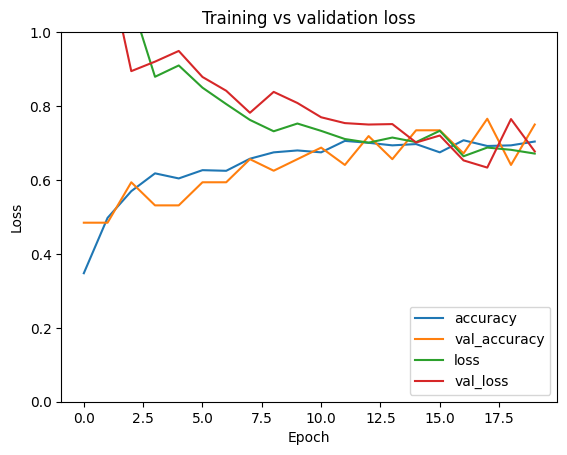

In [26]:
model.save('/content/CNN_model.h5')

# Cargar el modelo guardado
model = load_model('/content/CNN_model.h5')

# Evaluación del modelo
test_loss, test_acc = model.evaluate(test_data)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Graficar la precisión de entrenamiento vs. precisión de validación durante el entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training vs validation accuracy')

# Graficar la pérdida de entrenamiento vs. pérdida de validación durante el entrenamiento
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training vs validation loss')

# Cargar el modelo en el mejor punto de control
model_best = load_model('/content/best_model_CNN.hdf5')
test_loss, test_acc = model_best.evaluate(test_data)
